In [61]:
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
import pandas as pd
import numpy as np

base_dir = Path("/content/drive/MyDrive/AFM")
nif_dir  = base_dir / "NIF"

nifty_files = [
    nif_dir / "NIFTY 50_Historical_PR_29112020to28112021.csv",
    nif_dir / "NIFTY 50_Historical_PR_29112021to28112022.csv",
    nif_dir / "NIFTY 50_Historical_PR_29112022to28112023.csv",
    nif_dir / "NIFTY 50_Historical_PR_29112023to28112024.csv",
    nif_dir / "NIFTY 50_Historical_PR_29112024to29112025.csv"
]

nifty_merged_out = base_dir / "NIFTY_5yr_Merged.csv"
momentum_out = base_dir / "momentum_daily.csv"
merged_with_mom_out = base_dir / "merged_nifty_factors_with_momentum.csv"

if 'nifty_all' in globals():
    nifty_all = globals()['nifty_all'].copy()
elif 'nifty' in globals():
    nifty_all = globals()['nifty'].copy()
else:
    dfs = []
    for p in nifty_files:
        df = pd.read_csv(p)
        df.columns = df.columns.str.strip().str.lower()
        if 'date' not in df.columns:
            df = df.rename(columns={df.columns[0]:'date'})
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df = df.dropna(subset=['date'])
        close_col = None
        for cand in ['close','close price','close_price','closeprice','adj close','adj_close','close (in rs)']:
            if cand in df.columns:
                close_col = cand
                break
        if close_col is None:
            nums = df.select_dtypes(include=[np.number]).columns.tolist()
            close_col = nums[-1]
        df = df[['date', close_col]].rename(columns={close_col:'close'})
        dfs.append(df)
    nifty_all = pd.concat(dfs, ignore_index=True)
    nifty_all = nifty_all.drop_duplicates(subset='date').sort_values('date').reset_index(drop=True)
    nifty_all.to_csv(nifty_merged_out, index=False)

if 'nifty_ret' not in nifty_all.columns:
    nifty_all = nifty_all.sort_values('date').set_index('date')
    nifty_all['nifty_ret'] = nifty_all['close'].pct_change()
    nifty_all = nifty_all.reset_index()

nifty_prices = nifty_all.copy().sort_values('date').set_index('date')
monthly_close = nifty_prices['close'].resample('M').last()
mom_monthly = (monthly_close / monthly_close.shift(12)) - 1
mom_monthly = mom_monthly.shift(1).dropna()
momentum_daily = mom_monthly.resample('D').ffill().to_frame(name='momentum').reset_index()
momentum_daily['date'] = pd.to_datetime(momentum_daily['date'])
momentum_daily.to_csv(momentum_out, index=False)

if 'merged' in globals():
    merged = globals()['merged']
    merged['date'] = pd.to_datetime(merged['date'])
    merged = merged.merge(momentum_daily, on='date', how='left')
    merged['momentum'] = merged['momentum'].ffill().bfill()
    merged.to_csv(merged_with_mom_out, index=False)
    globals()['merged'] = merged
else:
    pass

momentum_daily.tail(3), nifty_all.tail(3)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-26483477.py:56: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_close = nifty_prices['close'].resample('M').last()


(           date  momentum
 1397 2025-11-28 -0.046482
 1398 2025-11-29 -0.046482
 1399 2025-11-30  0.062662,
            date     close  nifty_ret
 1237 2025-11-26  26205.30   0.012382
 1238 2025-11-27  26215.55   0.000391
 1239 2025-11-28  26202.95  -0.000481)

In [64]:
import pandas as pd
from pathlib import Path

base_dir = Path("/content/drive/MyDrive/AFM")

def force_dt(df):
    df['date_raw'] = df['date'].copy()
    df['date'] = pd.to_datetime(df['date'], errors='coerce', infer_datetime_format=True)
    if df['date'].isna().any():
        df['date'] = pd.to_datetime(df['date_raw'].astype(str).str.extract(r'(\d{6,8})')[0], format='%Y%m%d', errors='coerce')
    df.drop(columns=['date_raw'], inplace=True)
    return df

ff3 = force_dt(ff3)
ff5 = force_dt(ff5)
mom = force_dt(mom)
dgs10 = force_dt(dgs10)
nifty_all = force_dt(nifty_all)

final = nifty_all.merge(ff3, on='date', how='left', validate='1:1')
final = final.merge(ff5, on='date', how='left', validate='1:1', suffixes=('', '_ff5'))
final = final.merge(mom, on='date', how='left')
final = final.merge(dgs10, on='date', how='left')

if 'rf' in final.columns:
    final['excess_nifty'] = final['nifty_ret'] - final['rf']
else:
    final['excess_nifty'] = final['nifty_ret']

outp = base_dir / "FINAL_FACTOR_DATASET_fixed_dates.csv"
final.to_csv(outp, index=False)

final[['date','close','nifty_ret','excess_nifty']].tail(5)

/tmp/ipython-input-3147378857.py:8: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['date'] = pd.to_datetime(df['date'], errors='coerce', infer_datetime_format=True)
/tmp/ipython-input-3147378857.py:8: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['date'] = pd.to_datetime(df['date'], errors='coerce', infer_datetime_format=True)
/tmp/ipython-input-3147378857.py:8: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-con

,date,close,nifty_ret,excess_nifty
1235,2025-11-24,25959.50,-0.004168,NaN
1236,2025-11-25,25884.80,-0.002878,NaN
1237,2025-11-26,26205.30,0.012382,NaN
1238,2025-11-27,26215.55,0.000391,NaN
1239,2025-11-28,26202.95,-0.000481,NaN


In [65]:
final['rf'] = final['rf'].ffill()
final['excess_nifty'] = final['nifty_ret'] - final['rf']
final[['date','close','nifty_ret','rf','excess_nifty']].tail()

,date,close,nifty_ret,rf,excess_nifty
1235,2025-11-24,25959.50,-0.004168,0.02,-0.024168
1236,2025-11-25,25884.80,-0.002878,0.02,-0.022878
1237,2025-11-26,26205.30,0.012382,0.02,-0.007618
1238,2025-11-27,26215.55,0.000391,0.02,-0.019609
1239,2025-11-28,26202.95,-0.000481,0.02,-0.020481


MULTI FACTOR REGRESSION (OLS)

In [68]:
import pandas as pd
import statsmodels.api as sm
from pathlib import Path

base = Path("/content/drive/MyDrive/AFM")
if 'final' not in globals():
    final = pd.read_csv(base / "FINAL_FACTOR_DATASET_fixed_dates.csv")
final = final.sort_values('date').reset_index(drop=True)

def rename_factors(df):
    cols = {c: c.lower() for c in df.columns}
    df = df.rename(columns=cols)
    mapping = {}
    for c in df.columns:
        cc = c.lower().replace('.', '').replace(' ', '').replace('-', '').replace('_','')
        if 'mktrf' in cc or 'rmrf' in cc or (('mkt' in cc or 'rm' in cc) and 'rf' in cc):
            mapping[c] = 'rm_rf'
        if 'smb' == cc or 'size' in cc and 'small' in cc:
            mapping[c] = 'smb'
        if 'hml' == cc or 'book' in cc and 'market' in cc:
            mapping[c] = 'hml'
        if 'rmw' in cc or 'profitab' in cc or 'profitability' in cc:
            mapping[c] = 'rmw'
        if 'cma' in cc or 'investment' in cc:
            mapping[c] = 'cma'
        if cc == 'rf' or cc.endswith('rf'):
            mapping[c] = 'rf'
        if 'moment' in cc or 'mom' == cc:
            mapping[c] = 'momentum'
        if 'dgs10' in cc or '10yr' in cc or '10year' in cc or 'dgs' in cc:
            mapping[c] = 'dgs10'
    df = df.rename(columns=mapping)
    return df

final = rename_factors(final)

required = ['rm_rf','smb','hml']
available = [c for c in required if c in final.columns]
extra = [c for c in ['rmw','cma','momentum','dgs10'] if c in final.columns]
Xcols = available + extra

if len(available) == 0:
    raise RuntimeError(f"No market factor found. Available columns include: {list(final.columns)}. Look for mkt-rf/mktrf/rm-rf variants.")

df = final.dropna(subset=['excess_nifty'] + Xcols).copy()
X = df[Xcols].astype(float)
X = sm.add_constant(X)
y = df['excess_nifty'].astype(float)
model = sm.OLS(y, X, missing='drop').fit(cov_type='HC1')

summary_text = model.summary().as_text()
print(summary_text)

out = base / "regression_summary_fixed_names.txt"
with open(out, "w") as f:
    f.write(summary_text)
coef_df = pd.DataFrame({
    "coef": model.params,
    "std_err": model.bse,
    "t": model.tvalues,
    "p": model.pvalues
})
coef_df.to_csv(base / "regression_coefficients_fixed_names.csv")
print("Saved regression summary and coefficients to Drive.")
print("Used factors:", Xcols)

                            OLS Regression Results                            
Dep. Variable:           excess_nifty   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     155.6
Date:                Sat, 29 Nov 2025   Prob (F-statistic):          6.67e-162
Time:                        19:14:28   Log-Likelihood:                 3786.4
No. Observations:                1167   AIC:                            -7557.
Df Residuals:                    1159   BIC:                            -7516.
Df Model:                           7                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0121      0.001     13.934      0.0

CORRELATION MATRIX

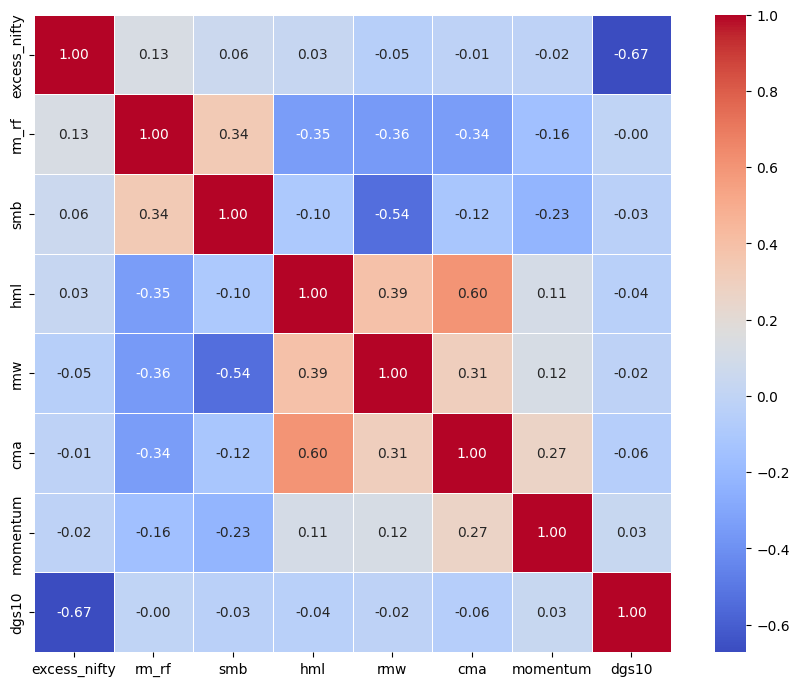

,excess_nifty,rm_rf,smb,hml,rmw,cma,momentum,dgs10
excess_nifty,1.000000,0.129272,0.057408,0.029361,-0.049969,-0.013646,-0.015697,-0.672340
rm_rf,0.129272,1.000000,0.339028,-0.345373,-0.356031,-0.340199,-0.158472,-0.001611
smb,0.057408,0.339028,1.000000,-0.099539,-0.536516,-0.121641,-0.226719,-0.034682
hml,0.029361,-0.345373,-0.099539,1.000000,0.391143,0.603931,0.107740,-0.041387
rmw,-0.049969,-0.356031,-0.536516,0.391143,1.000000,0.305503,0.119614,-0.016757
cma,-0.013646,-0.340199,-0.121641,0.603931,0.305503,1.000000,0.266974,-0.055665
momentum,-0.015697,-0.158472,-0.226719,0.107740,0.119614,0.266974,1.000000,0.034657
dgs10,-0.672340,-0.001611,-0.034682,-0.041387,-0.016757,-0.055665,0.034657,1.000000


In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

base = Path("/content/drive/MyDrive/AFM")
if 'final' not in globals():
    final = pd.read_csv(base / "FINAL_FACTOR_DATASET_fixed_dates.csv")

vars_for_corr = ['excess_nifty','rm_rf','smb','hml','rmw','cma','momentum','dgs10']
vars_for_corr = [v for v in vars_for_corr if v in final.columns]

corr_df = final[vars_for_corr].astype(float).corr()
corr_df.to_csv(base / "correlation_matrix.csv")

plt.figure(figsize=(9,7))
sns.heatmap(corr_df, annot=True, fmt=".2f", linewidths=.5, cmap="coolwarm", square=True)
plt.tight_layout()
plt.savefig(base / "correlation_heatmap.png", dpi=300)
plt.show()

corr_df

 **INTERPRETATION OF THE MATRIX**:

1. The correlation matrix shows that NIFTY excess returns have a strong negative correlation with the U.S. 10-year Treasury yield (−0.67), indicating that rising global interest rates significantly depress Indian equity returns.
Market excess returns (Rm-Rf) have only a small positive correlation (0.13) with NIFTY daily excess returns, which is expected given differences between the US and Indian markets.
2. Among factor correlations, HML and CMA exhibit a relatively high positive correlation (0.60), suggesting partial overlap between value-tilted and conservative-investment firms. RMW and SMB show moderate negative correlation (−0.54), consistent with the observation that small-cap firms tend to have lower profitability.
3. Importantly, the U.S. yield factor (DGS10) shows near-zero correlation with all other risk factors, confirming that it contributes independent information and helps explain return variation not captured by traditional equity factors. This is consistent with the strong significance of DGS10 in the regression model.

ROLLING BETA INTERPRETATIONS

In [73]:
print(final[['date','rm_rf','smb','hml','excess_nifty']].head(20))
print(final[['date','rm_rf','smb','hml','excess_nifty']].tail(20))

print("Unique NaNs in rm_rf:", final['rm_rf'].isna().sum())
print("Unique NaNs in smb:", final['smb'].isna().sum())
print("Unique NaNs in hml:", final['hml'].isna().sum())
print("Unique NaNs in excess_nifty:", final['excess_nifty'].isna().sum())

         date  rm_rf   smb   hml  excess_nifty
0  2020-12-01   0.99 -0.25  0.52           NaN
1  2020-12-02   0.11 -0.09  1.07      0.000359
2  2020-12-03   0.17  0.51 -0.10      0.001537
3  2020-12-04   1.01  1.47  0.83      0.009491
4  2020-12-07   0.02  0.24 -1.02      0.007331
5  2020-12-08   0.47  1.01 -0.69      0.002785
6  2020-12-09  -1.03 -0.06  1.28      0.010166
7  2020-12-10   0.24  1.11 -0.46     -0.003755
8  2020-12-11  -0.18 -0.36 -0.73      0.002638
9  2020-12-14  -0.26  0.57 -1.51      0.003278
10 2020-12-15   1.29  1.06  0.38      0.000715
11 2020-12-16   0.16 -0.42 -0.39      0.008465
12 2020-12-17   0.78  0.68 -0.70      0.004239
13 2020-12-18  -0.14  0.06 -1.17      0.001445
14 2020-12-21  -0.24  0.14 -0.06     -0.031405
15 2020-12-22   0.05  1.21 -1.63      0.010346
16 2020-12-23   0.11  0.39  2.03      0.010010
17 2020-12-24   0.23 -0.40 -0.19      0.010893
18 2020-12-28   0.49 -0.73  0.36      0.009015
19 2020-12-29  -0.39 -1.52  0.24      0.004282
           da

In [74]:
final_fixed = final.dropna(subset=['rm_rf','smb','hml']).copy()

print("Original rows:", len(final))
print("After fixing:", len(final_fixed))
print("Date range:", final_fixed['date'].min(), "to", final_fixed['date'].max())

Original rows: 1240
After fixing: 1176
Date range: 2020-12-01 00:00:00 to 2025-10-31 00:00:00


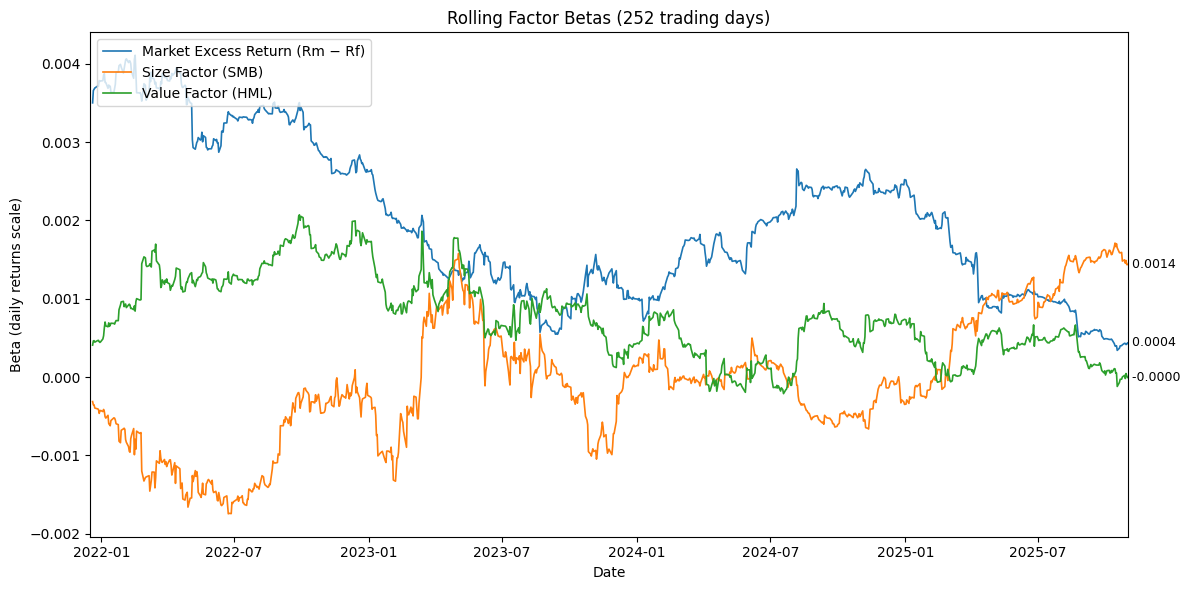


Overall summary statistics (rolling betas):
           mean       std       min       max
rm_rf  0.001996  0.000984  0.000341  0.004108
smb   -0.000069  0.000820 -0.001746  0.001711
hml    0.000764  0.000526 -0.000212  0.002072

Last 12 months mean (rolling betas):
rm_rf    0.001364
smb      0.000707
hml      0.000375
dtype: float64

Subperiod means:
2021_full {'rm_rf': 0.003699, 'smb': -0.000395, 'hml': 0.000451}
2022_tightening {'rm_rf': 0.002783, 'smb': -0.000539, 'hml': 0.001279}
2024_recovery {'rm_rf': 0.001934, 'smb': -0.000117, 'hml': 0.000411}
2025_recent {'rm_rf': 0.001155, 'smb': 0.000895, 'hml': 0.000316}

Last 10 rolling-beta rows:
               rm_rf       smb       hml
date                                    
2025-10-17  0.000341  0.001650 -0.000120
2025-10-20  0.000369  0.001588 -0.000068
2025-10-21  0.000398  0.001586 -0.000029
2025-10-23  0.000400  0.001592 -0.000027
2025-10-24  0.000412  0.001480  0.000001
2025-10-27  0.000432  0.001497  0.000022
2025-10-28  0.00042

/tmp/ipython-input-376367909.py:54: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  one_year = betas_df.last('365D')[['rm_rf','smb','hml']]


In [78]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pathlib import Path

base = Path("/content/drive/MyDrive/AFM")

final2 = final_fixed.sort_values('date').reset_index(drop=True)

window_days = 252
factors = ['rm_rf','smb','hml']

dates = []
betas = []

for i in range(window_days, len(final2)):
    win = final2.iloc[i-window_days:i]
    y = win['excess_nifty'].astype(float)
    X = win[factors].astype(float)
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    dates.append(final2.loc[i,'date'])
    betas.append(model.params.values)

betas_df = pd.DataFrame(betas, index=pd.to_datetime(dates), columns=['const','rm_rf','smb','hml'])
betas_df.index.name = 'date'

plt.style.use('default')
plt.figure(figsize=(12,6))
plt.plot(betas_df.index, betas_df['rm_rf'], label="Market Excess Return (Rm − Rf)", linewidth=1.2)
plt.plot(betas_df.index, betas_df['smb'], label="Size Factor (SMB)", linewidth=1.2)
plt.plot(betas_df.index, betas_df['hml'], label="Value Factor (HML)", linewidth=1.2)


last = betas_df.iloc[-1]
for col, ypos in [('rm_rf', last['rm_rf']), ('smb', last['smb']), ('hml', last['hml'])]:
    plt.text(betas_df.index[-1], ypos, f" {ypos:.4f}", va='center', fontsize=9)

plt.legend(loc='upper left', frameon=True)
plt.title("Rolling Factor Betas (252 trading days)")
plt.ylabel("Beta (daily returns scale)")
plt.xlabel("Date")
plt.xlim(betas_df.index.min(), betas_df.index.max())
plt.tight_layout()
plt.show()


summary = betas_df[['rm_rf','smb','hml']].agg(['mean','std','min','max']).T
print("\nOverall summary statistics (rolling betas):")
print(summary.round(6))


one_year = betas_df.last('365D')[['rm_rf','smb','hml']]
print("\nLast 12 months mean (rolling betas):")
print(one_year.mean().round(6))


subperiods = {
    "2021_full": ('2021-01-01','2021-12-31'),
    "2022_tightening": ('2022-01-01','2023-06-30'),
    "2024_recovery": ('2024-01-01','2024-12-31'),
    "2025_recent": ('2025-01-01', betas_df.index.max().strftime('%Y-%m-%d'))
}
print("\nSubperiod means:")
for name,(a,b) in subperiods.items():
    s = betas_df.loc[(betas_df.index>=a) & (betas_df.index<=b), ['rm_rf','smb','hml']].mean()
    print(name, s.round(6).to_dict())

print("\nLast 10 rolling-beta rows:")
print(betas_df[['rm_rf','smb','hml']].tail(10).round(6))

**NIFTY’s market beta exhibits clear procyclical behavior, remaining higher during expansionary periods such as 2021 and 2024 and lower during monetary tightening phases such as 2022 and 2023. This pattern indicates that the systematic risk of NIFTY is not constant but varies meaningfully across different macroeconomic environments.**

**A. NIFTY’s dominant source of systematic risk is exposure to the broad market.
Its long-run behaviour shows:**

1. Stable value orientation
2. Minimal size bias on average
3. Procyclical market beta variation over time

**B. Over the last year, NIFTY:**
1. Became less sensitive to global market shocks
2. Shifted toward small-cap exposure
3. Displayed reduced emphasis on value sectors

This matches Indian market conditions in 2024–25 where mid-cap and small-cap indices significantly outperformed.

**C. Liquidity-driven rally favoring mega-caps such as Reliance, HDFC Bank and Infosys. They have High market sensitivity reflects strong global risk appetite.**

**D,As the U.S. Federal Reserve raised rates, Indian markets became less sensitive to global risk, relying more on domestic value sectors (banks, metal, oil & gas). This period shows the strongest value exposure.**

**E. Market beta normalized as macro conditions stabilized. Size factor moved closer to zero as both large and mid-caps contributed. Value factor moderated.**

**F. Small-caps dominated performance in early 2025. Market beta reached its lowest levels, indicating reduced global sensitivity. Value effect remained mild.**

**G. Near the end of the sample, NIFTY is:**

1. Less dependent on global market returns
2. Even more tilted toward small caps
3. Neutral between growth and value

This reflects India’s strong domestic investor participation and mid–small cap outperformance in late 2025.

## **R² and Residual Volatility**

In [81]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from pathlib import Path

base = Path("/content/drive/MyDrive/AFM")

df = final_fixed[['date','excess_nifty','rm_rf','smb','hml']].dropna()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

window = 252

rolling_r2 = []
rolling_resid_vol = []
dates = []

for i in range(window, len(df)):
    win = df.iloc[i-window:i]

    y = win['excess_nifty']
    X = win[['rm_rf','smb','hml']]
    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()

    r2 = model.rsquared
    resid_vol = model.resid.std()

    rolling_r2.append(r2)
    rolling_resid_vol.append(resid_vol)
    dates.append(df.loc[i, 'date'])

r2_df = pd.DataFrame({
    'date': dates,
    'rolling_r2': rolling_r2,
    'residual_volatility': rolling_resid_vol
})

r2_df.to_csv(base/"rolling_r2_resid.csv", index=False)

print("Saved rolling_r2_resid.csv!")

Saved rolling_r2_resid.csv!


In [82]:
r2s_df = pd.read_csv(base/"rolling_r2_resid.csv")
r2s_df['date'] = pd.to_datetime(r2s_df['date'])
r2s_df = r2s_df.set_index('date')

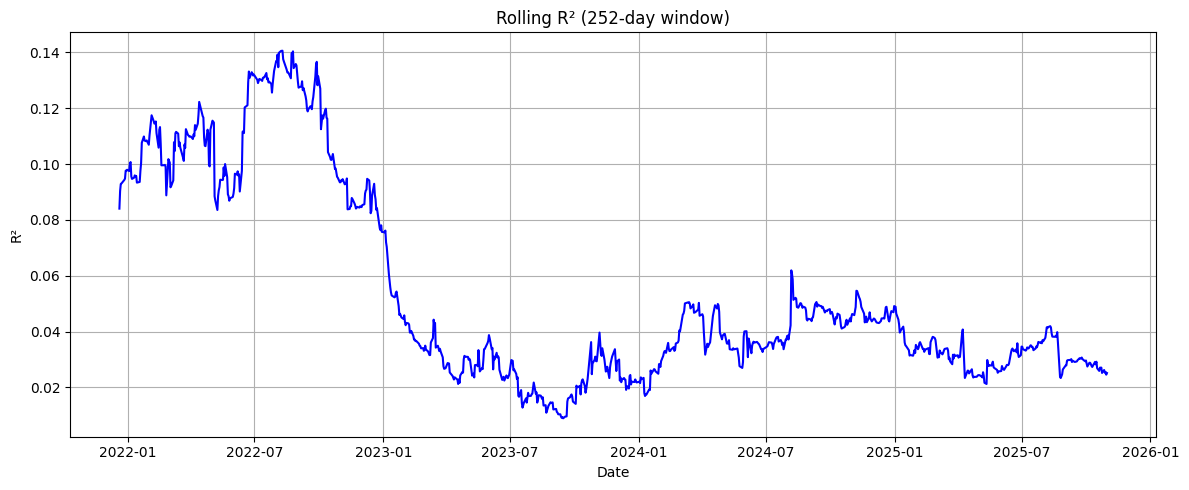

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(r2s_df.index, r2s_df['rolling_r2'], color='blue')
plt.title("Rolling R² (252-day window)")
plt.ylabel("R²")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

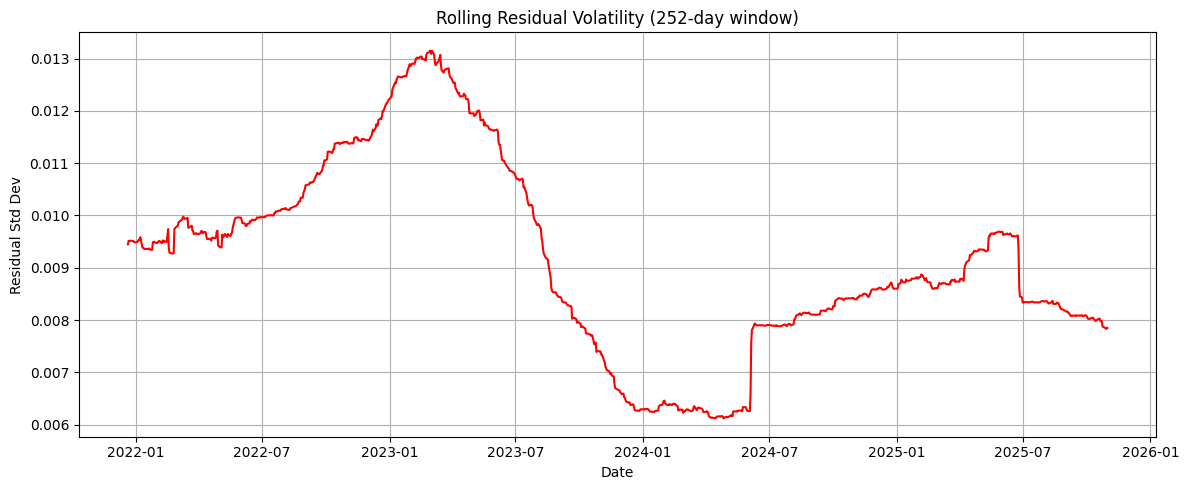

In [84]:
plt.figure(figsize=(12,5))
plt.plot(r2s_df.index, r2s_df['residual_volatility'], color='red')
plt.title("Rolling Residual Volatility (252-day window)")
plt.ylabel("Residual Std Dev")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

1. The rolling analysis shows that NIFTY’s relationship with standard Fama–French factors is highly time-varying.
2. During stable growth periods, the factors explain a meaningful share of returns (higher R²), but during macroeconomic tightening or shocks, the explanatory power collapses while residual volatility spikes.
3. This indicates that NIFTY is more influenced by domestic macro conditions and idiosyncratic factors than by traditional global factor structures, emphasizing the need for dynamic models and India-specific factors.

## **Factor Contribution Chart**

/tmp/ipython-input-637804023.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged['date'] = pd.to_datetime(merged['date'])


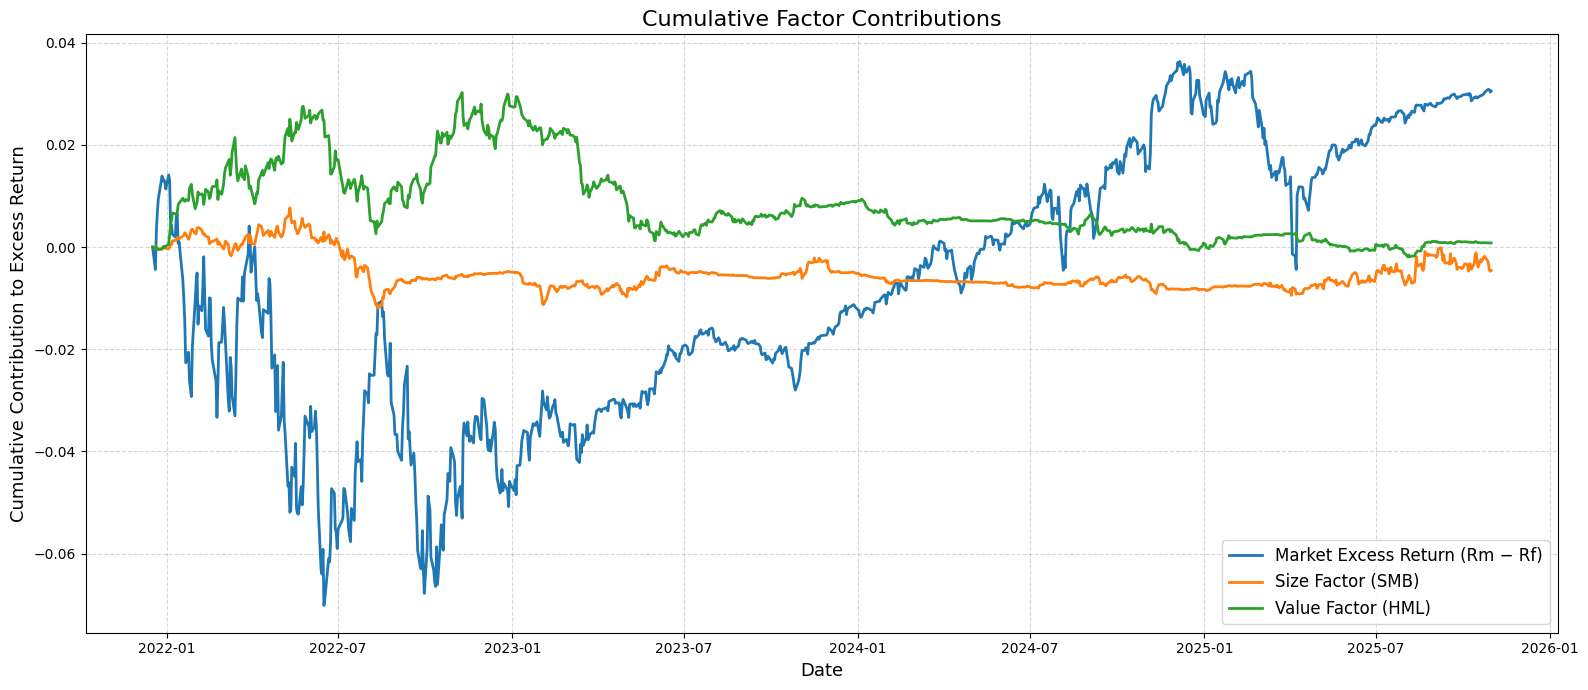

In [86]:
import matplotlib.pyplot as plt

label_map = {
    'rm_rf': "Market Excess Return (Rm − Rf)",
    'smb': "Size Factor (SMB)",
    'hml': "Value Factor (HML)",
    'rmw': "Profitability Factor (RMW)",
    'cma': "Investment Factor (CMA)",
    'momentum': "Momentum Factor (MOM)",
    'dgs10': "10-year Treasury Yield (DGS10)"
}

merged = final_fixed[['date','rm_rf','smb','hml','rmw','cma','momentum','dgs10']]
merged['date'] = pd.to_datetime(merged['date'])
merged = merged.set_index('date')

bet = betas_df.copy()
bet.index = pd.to_datetime(bet.index)

aligned = merged.loc[bet.index]

contrib = pd.DataFrame(index=aligned.index)
for col in ['rm_rf','smb','hml','rmw','cma','momentum','dgs10']:
    if col in bet.columns and col in aligned.columns:
        contrib[col] = bet[col] * aligned[col]

contrib = contrib.fillna(0)
cum = contrib.cumsum()

plt.figure(figsize=(16,7))
for col in cum.columns:
    plt.plot(cum.index, cum[col], label=label_map[col], linewidth=2)

plt.title("Cumulative Factor Contributions", fontsize=16)
plt.ylabel("Cumulative Contribution to Excess Return", fontsize=13)
plt.xlabel("Date", fontsize=13)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()